In [35]:
# Basic Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Model
from xgboost import XGBClassifier, plot_importance

# Visualization
import matplotlib.pyplot as plt

# Save/Load Model
import joblib


In [36]:
# Load your dataset
df = pd.read_csv("kochi_metro_extended_dataset_100.csv")

# Preview
df.head()


,Trainset_ID,Fitness_Certificate_Status,Job_Card_Status,Branding_Hours_Left,Mileage_Today_km,Cleaning_Slot_Available,Stabling_Position,Total_Km_Travelled,Metro_Age_Years,Planned_Km_Tomorrow,Stabling_Geometry,IBL_Availability,Energy_Consumption_Index,Brake_Pad_Wear_Percent,HVAC_Efficiency,Telecom_Clearance,Decision
0,Train_1,ExpiringSoon,Pending,179,469,Yes,7,24397,5,390,Suboptimal,Occupied,1.20,24,86.11,Yes,Standby
1,Train_2,Valid,Pending,112,471,No,5,182627,6,115,Suboptimal,Available,1.39,89,69.53,No,IBL
2,Train_3,ExpiringSoon,Pending,61,153,Yes,5,188031,5,124,Optimal,Occupied,0.90,74,63.98,No,IBL
3,Train_4,ExpiringSoon,Open,185,389,No,7,141800,5,152,Suboptimal,Occupied,1.36,37,69.73,Yes,IBL
4,Train_5,Valid,Pending,51,303,Yes,9,191589,4,241,Suboptimal,Available,0.94,1,88.89,Yes,IBL


In [6]:
import sys
!{sys.executable} -m pip install matplotlib --upgrade


In [19]:
import sys
print(sys.executable)


c:\Users\sharm\OneDrive\Desktop\sih\venv\Scripts\python.exe


In [38]:
# Separate features and target
X = df.drop("Decision", axis=1)
y = df["Decision"]

# Encode categorical columns
label_encoders = {}
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode target
y_le = LabelEncoder()
y = y_le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [39]:
# Initialize and train XGBoost
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

model.fit(X_train, y_train)


c:\Users\sharm\OneDrive\Desktop\sih\venvs\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:14:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


Accuracy: 0.3

Classification Report:

              precision    recall  f1-score   support

         IBL       0.29      0.40      0.33         5
     Service       0.29      0.25      0.27         8
     Standby       0.33      0.29      0.31         7

    accuracy                           0.30        20
   macro avg       0.30      0.31      0.30        20
weighted avg       0.30      0.30      0.30        20



<Figure size 1000x600 with 0 Axes>

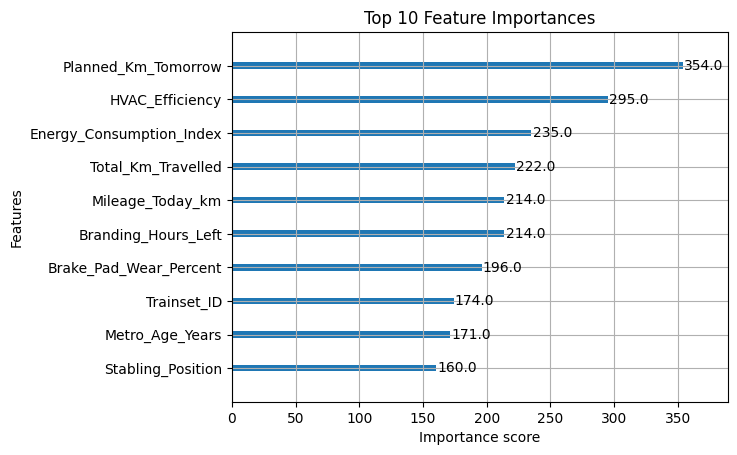

In [16]:
# Predictions
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=y_le.classes_))

# Feature importance
plt.figure(figsize=(10,6))
plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


In [43]:
# Predict probabilities for all trains
probs = model.predict_proba(X)

# Get index for "Service" class
service_index = list(y_le.classes_).index("Service")

# Add probability of being in Service
df["Service_Probability"] = probs[:, service_index]

# Add final predicted decision (Revenue Service, Standby, IBL, etc.)
df["Predicted_Decision"] = y_le.inverse_transform(model.predict(X))

# Top 10 trains with decision + probability
top_10_trains = df.sort_values(by="Service_Probability", ascending=False).head(30)

print("Top 10 trains likely to depart tomorrow:")
print(top_10_trains[["Trainset_ID", "Predicted_Decision", "Service_Probability"]])


Top 10 trains likely to depart tomorrow:
   Trainset_ID Predicted_Decision  Service_Probability
57    Train_58            Service             0.988811
92    Train_93            Service             0.985410
79    Train_80            Service             0.981856
61    Train_62            Service             0.981601
99   Train_100            Service             0.981564
38    Train_39            Service             0.980479
56    Train_57            Service             0.976438
36    Train_37            Service             0.976139
94    Train_95            Service             0.975151
35    Train_36            Service             0.974179
6      Train_7            Service             0.971804
30    Train_31            Service             0.970212
24    Train_25            Service             0.970028
55    Train_56            Service             0.968667
69    Train_70            Service             0.966040
9     Train_10            Service             0.964327
33    Train_34          

In [47]:
# Predict probabilities for all trains
probs = model.predict_proba(X)

# Get index for "Service" class
service_index = list(y_le.classes_).index("Service")

# Add probability of being in Service
df["Service_Probability"] = probs[:, service_index]

# Add final predicted decision
df["Predicted_Decision"] = y_le.inverse_transform(model.predict(X))

# Add actual decision from dataset
df["Actual_Decision"] = y_le.inverse_transform(y)

# Top 10 trains (highest Service probability)
top_10_trains = df.sort_values(by="Service_Probability", ascending=False).head(40)

print("Top 10 trains likely to depart tomorrow:")
print(top_10_trains[["Trainset_ID", "Actual_Decision", "Predicted_Decision", "Service_Probability"]])


Top 10 trains likely to depart tomorrow:
   Trainset_ID Actual_Decision Predicted_Decision  Service_Probability
57    Train_58         Service            Service             0.988811
92    Train_93         Service            Service             0.985410
79    Train_80         Service            Service             0.981856
61    Train_62         Service            Service             0.981601
99   Train_100         Service            Service             0.981564
38    Train_39         Service            Service             0.980479
56    Train_57         Service            Service             0.976438
36    Train_37         Service            Service             0.976139
94    Train_95         Service            Service             0.975151
35    Train_36         Service            Service             0.974179
6      Train_7         Service            Service             0.971804
30    Train_31         Service            Service             0.970212
24    Train_25         Service      

In [10]:
# Save the model
joblib.dump(model, "xgb_kochi_metro.pkl")

# Save label encoders for reuse
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(y_le, "target_encoder.pkl")


['target_encoder.pkl']

In [11]:
# Load model
loaded_model = joblib.load("xgb_kochi_metro.pkl")

# Load encoders
loaded_label_encoders = joblib.load("label_encoders.pkl")
loaded_y_encoder = joblib.load("target_encoder.pkl")

print("Model and encoders loaded successfully!")


Model and encoders loaded successfully!


In [27]:
print(df.columns)


Index(['Trainset_ID', 'Fitness_Certificate_Status', 'Job_Card_Status',
       'Branding_Hours_Left', 'Mileage_Today_km', 'Cleaning_Slot_Available',
       'Stabling_Position', 'Total_Km_Travelled', 'Metro_Age_Years',
       'Planned_Km_Tomorrow', 'Stabling_Geometry', 'IBL_Availability',
       'Energy_Consumption_Index', 'Brake_Pad_Wear_Percent', 'HVAC_Efficiency',
       'Telecom_Clearance', 'Decision'],
      dtype='object')


In [32]:
print(df.columns.tolist())


['Trainset_ID', 'Fitness_Certificate_Status', 'Job_Card_Status', 'Branding_Hours_Left', 'Mileage_Today_km', 'Cleaning_Slot_Available', 'Stabling_Position', 'Total_Km_Travelled', 'Metro_Age_Years', 'Planned_Km_Tomorrow', 'Stabling_Geometry', 'IBL_Availability', 'Energy_Consumption_Index', 'Brake_Pad_Wear_Percent', 'HVAC_Efficiency', 'Telecom_Clearance', 'Decision']
